In [1]:
# Makes a fake FITS frame for testing generation of pixel scale, or for testing Strehl ratio code

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from astropy.io import fits

In [ ]:
# Part 1: Inject Gaussians for pixel scale stuff

In [2]:
fov = 33.2 # arcsec

# coordinates (arbitrary scale) of stars in Fig. 2 of Close+ 2012
coords_stars = {'D2': np.array([149, 401]), 
                'C2': np.array([507, 593]), 
                'B1': np.array([657, 104]), 
                'E1': np.array([822, 199]), 
                'A2': np.array([796, 328]), 
                'A1': np.array([798, 335])}

In [3]:
def inject_gaussians(readout, coords, sigma):
    x_coords, y_coords = np.meshgrid(np.arange(readout.shape[1]), np.arange(readout.shape[0]))
    for key, value in coords.items():
        x, y = value
        gaussian = np.exp(-((x_coords - x)**2 + (y_coords - y)**2) / (2 * sigma**2))
        readout += gaussian
    return readout

In [ ]:
readout = np.zeros((1016, 1016))

In [5]:
_ = inject_gaussians(readout, coords=coords_stars, sigma=10)

In [ ]:
plt.imshow(readout)
plt.show()

In [8]:
# Part 2: Inject Gaussians with different FWHM for Strehl ratio testing

In [5]:
fov = 33.2 # arcsec

# noisy coordinates (to test Strehl ratio code)
coords_stars_noisy_1 = {'D2': np.array(np.random.normal((1, 2), scale=0.1) + [149, 401])}
coords_stars_noisy_2 = {'C2': np.array(np.random.normal((1, 2), scale=0.1) + [507, 593])} 
coords_stars_noisy_3 = {'B1': np.array(np.random.normal((1, 2), scale=0.1) + [657, 104])} 
coords_stars_noisy_4 = {'E1': np.array(np.random.normal((1, 2), scale=0.1) + [822, 199])} 
coords_stars_noisy_5 = {'A2': np.array(np.random.normal((1, 2), scale=0.1) + [796, 328])} 
coords_stars_noisy_6 = {'A1': np.array(np.random.normal((1, 2), scale=0.1) + [800, 800])}

In [4]:
# print those coordinates (letter codes don't matter)
print(coords_stars_noisy_1)
print(coords_stars_noisy_2)
print(coords_stars_noisy_3)
print(coords_stars_noisy_4)
print(coords_stars_noisy_5)
print(coords_stars_noisy_6)

{'D2': array([149.94899385, 402.9166701 ])}
{'C2': array([507.90924881, 594.91140539])}
{'B1': array([658.37946568, 106.0045639 ])}
{'E1': array([823.08359621, 201.05380537])}
{'A2': array([797.07983878, 329.99888102])}
{'A1': array([800.968366  , 802.11958826])}


In [2]:
# What size FWHM do we need?

'''
FWHM_tot = sqrt( FWHM_TBS ** 2 + FWHM_DIRAC ** 2 )

where 

FWHM_TBS = 44.76 um / ( 18 um/pix ) = 2.4867 pix
FWHM_DIRAC = 30.40 um / ( 18 um/pix ) = 1.6889 pix

So,

FWHM_tot = 3.006

If we want to inject spots with different strehls, 

FWHM_DIRAC,empirical = FWHM_DIRAC,perfect / sqrt(strehl)

then the total thing we need to inject is

FWHM_tot = sqrt( FWHM_TBS ** 2 + (FWHM_DIRAC,perfect ** 2) / strehl )
'''

fwhm_perfect = 3.006 # pix

def fwhm_total_from_strehl(strehl, FWHM_TBS, FWHM_DIRAC_perfect):
    # returns pixel FWHM of the TOTAL spot (i.e., includes effects of both TBS and DIRAC)
    # (should all be in pixel space)

    FWHM_tot = np.sqrt( FWHM_TBS ** 2 + (FWHM_DIRAC_perfect ** 2) / strehl )

    return FWHM_tot

fwhm_tot_1 = fwhm_total_from_strehl(strehl=1.0, FWHM_TBS = 2.4867, FWHM_DIRAC_perfect=1.6889)
fwhm_tot_2 = fwhm_total_from_strehl(strehl=0.98, FWHM_TBS = 2.4867, FWHM_DIRAC_perfect=1.6889)
fwhm_tot_3 = fwhm_total_from_strehl(strehl=0.96, FWHM_TBS = 2.4867, FWHM_DIRAC_perfect=1.6889)
fwhm_tot_4 = fwhm_total_from_strehl(strehl=0.92, FWHM_TBS = 2.4867, FWHM_DIRAC_perfect=1.6889)
fwhm_tot_5 = fwhm_total_from_strehl(strehl=0.85, FWHM_TBS = 2.4867, FWHM_DIRAC_perfect=1.6889)
fwhm_tot_6 = fwhm_total_from_strehl(strehl=0.6, FWHM_TBS = 2.4867, FWHM_DIRAC_perfect=1.6889)

In [21]:
print(fwhm_tot_1, fwhm_tot_2, fwhm_tot_3, fwhm_tot_4, fwhm_tot_5, fwhm_tot_6)

3.0060040086466953 3.01567106996849 3.0257080824852665 3.046981034172792 3.0885954482484714 3.3072116513260332


In [6]:
print('Measured sigmas should be',fwhm/2.355)

Measured sigmas should be 1.2764331210191082


In [16]:
def inject_gaussians_variable_strehl(readout, coords, sigma):
    # makes Gaussians with different Strehl values
    x_coords, y_coords = np.meshgrid(np.arange(readout.shape[1]), np.arange(readout.shape[0]))
    for key, value in coords.items():
        x, y = value
        gaussian = np.exp(-((x_coords - x)**2 + (y_coords - y)**2) / (2 * sigma**2))
        readout += gaussian

        # normalize PSFs, to make them comparable with real data
        readout /= np.max(readout)
        readout *= 20000

        # inject noise
        readout += np.random.normal(scale=219., size=np.shape(readout))

    return readout

In [11]:
np.shape(readout)

(1024, 1024)

In [22]:
readout = np.zeros((1024, 1024))

#_ = inject_gaussians_variable_strehl(readout, coords=coords_stars_noisy_6, sigma=fwhm_perfect/2.355)
_ = inject_gaussians_variable_strehl(readout, coords=coords_stars_noisy_5, sigma=fwhm_tot_5/2.355)

# Create a FITS HDU from the readout array
hdu = fits.PrimaryHDU(readout)

# Save the FITS file
hdu.writeto('junk_strehl_ratio_testing_readout_5.fits', overwrite=True)

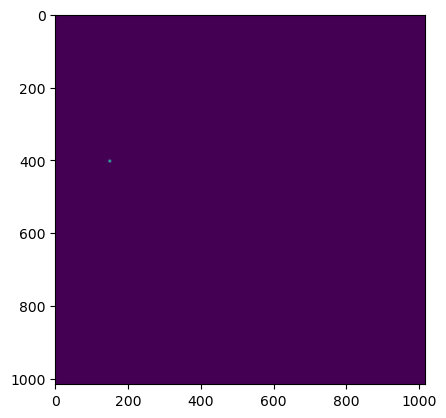

In [14]:
plt.clf()
plt.imshow(readout)
plt.show()

In [26]:
# Create a FITS HDU from the readout array
hdu = fits.PrimaryHDU(readout)

# Save the FITS file
hdu.writeto('junk_strehl_ratio_testing_readout_3.fits', overwrite=True)

In [13]:
# fake darks

readout_dark = np.zeros((1024, 1024))
hdu = fits.PrimaryHDU(readout_dark)
hdu.writeto('junk_dark.fits', overwrite=True)

In [34]:
# read in a real frame and measure the noise
fits_file = '/Users/bandari/Documents/git.repos/dirac/vtp_scripts_data/nirao_14_image_quality/data/20240710/DIRAC_20240710_103844.fits'
data = fits.getdata(fits_file)

# find the median in a 100x100 region
stdev_frame = np.std(data[100:200, 100:200])

print(stdev_frame)

219.31102124314228
